## Stock Data Analysis and Prediction with Python

In [2]:
# install tushare to get China A-share data http://tushare.org/
!pip install tushare
# install yfinance to get US stock data https://pypi.org/project/yfinance/
!pip install yfinance
# install pyramid-arima to use auto_arima
!pip install pyramid-arima

     |████████████████████████████████| 215kB 9.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.52-py2.py3-none-any.whl size=21997 sha256=13bba135580515dc2f7143dd445150c23d18c1a1650f08636cc096d1af0c2218
  Stored in directory: /root/.cache/pip/wheels/1b/9d/ce/929e851fc7d649cd962c177220ad985675785aa97c54df5714
Successfully built yfinance
     |████████████████████████████████| 604kB 9.5MB/s 


In [0]:
import pandas as pd
import numpy as np
import tushare as ts
import yfinance as yf
from fastai.tabular.transform import add_datepart
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Get US Stocks Data
import yfinance as yf
baba=yf.Ticker("BABA")
histdata = baba.history(period="max")
USdata = yf.download("BABA", start="2017-12-01", end="2019-12-01")
data=USdata[['Close']]
data=data.sort_index(ascending=True,axis=0)

[*********************100%***********************]  1 of 1 completed


In [0]:
# Get A Stock data
ts.set_token('ddd7bdd30799c09e4b87c739303f9f783a26270f91537a5458516ef7')
pro = ts.pro_api()
Adata = pro.daily(ts_code='000651.SZ', start_date='20181201', end_date='20191201')
Adata.index=pd.to_datetime(Adata['trade_date'])
data=Adata[['trade_date','close']]
data.columns=['Date','Close']
data.index=pd.to_datetime(data['Date'])
data=data[['Close']]
data=data.sort_index(ascending=True,axis=0)

### Plot Stock data Time series

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


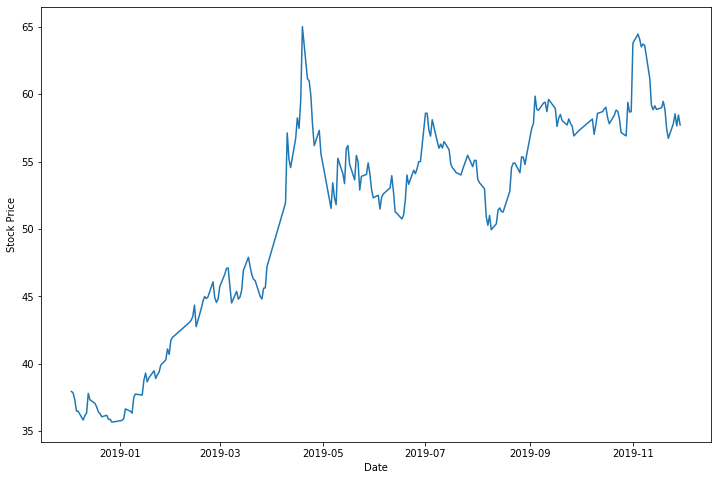

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

### Create new time variables and divide the data set into training and test sets

In [7]:
from fastai.tabular.transform import add_datepart
new_data=data.reset_index()
add_datepart(new_data,'Date')
new_data.drop('Elapsed',axis=1,inplace=True)
new_data.index=data.index
train_num=int(len(data)*0.8)
train = new_data[:train_num+1]# 为了防止测试集和训练集的时间序列画在一张图上出现断点，直接将训练集多取一个点
test = new_data[train_num:]
x_train = train.drop('Close', axis=1)#去掉Close，剩下的作为特征
y_train = train[['Close']]# Close即是target
x_test = test.drop('Close', axis=1)
y_test = test[['Close']]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((190, 12), (48, 12), (190, 1), (48, 1))

### LinearRegression

LinearRegression Prediction RMSE: 2.479530288303038


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


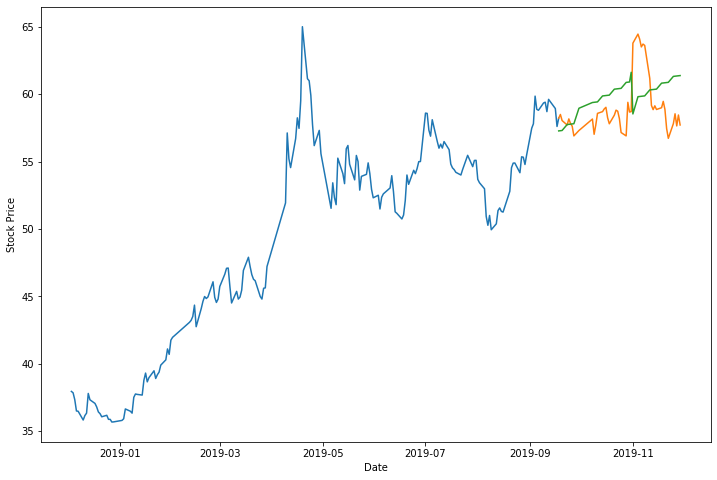

In [9]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
lr=LinearRegression()
lr.fit(x_train,y_train)
y_predict=lr.predict(x_test)
print('LinearRegression Prediction RMSE:',np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_predict)),2))))
plt.figure(figsize=(12,8))
test['Predict']=y_predict
plt.plot(train['Close'])
plt.plot(test[['Close','Predict']])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

### KNN

KNeighborsRegressor Prediction RMSE:: 19.898705949864343


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


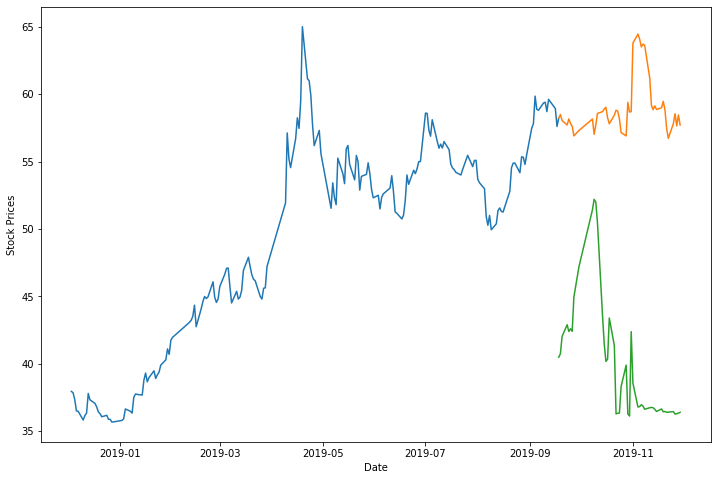

In [12]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_train_scaled.columns=x_train.columns
x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)
x_test_scaled.columns = x_test.columns

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(x_train_scaled,y_train)
y_predict = model.predict(x_test_scaled)
print('KNeighborsRegressor Prediction RMSE::',np.sqrt(np.mean(np.power((np.array(y_test)-np.array(y_predict)),2))))

plt.figure(figsize=(12,8))
test['Predict']=y_predict
plt.plot(train['Close'])
plt.plot(test[['Close','Predict']])
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.show()

### ARIMA

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=612.105, BIC=627.986, Fit time=4.232 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=715.976, BIC=722.328, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=667.958, BIC=680.663, Fit time=0.441 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=615.848, BIC=628.553, Fit time=1.544 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=613.736, BIC=632.793, Fit time=2.040 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=705.545, BIC=718.249, Fit time=0.557 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=613.700, BIC=632.757, Fit time=7.479 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=611.751, BIC=633.984, Fit time=10.793 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=615.086, BIC=634.143, Fit time=7.798 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


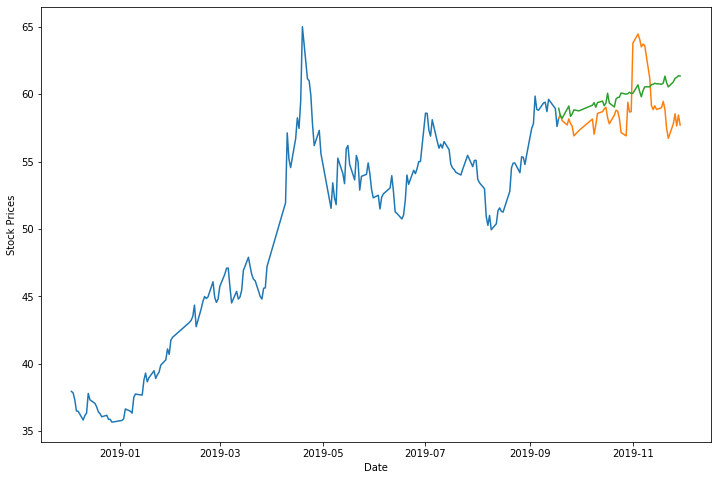

In [14]:
from pyramid.arima import auto_arima
train_num=int(len(data)*0.8)
train=data[:train_num+1]
test=data[train_num:]
arima_model = auto_arima(train['Close'], start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
arima_model.fit(train['Close'])
predict_price = arima_model.predict(n_periods=(len(data)-train_num))
predict_price = pd.DataFrame(predict_price,index = test.index,columns=['Prediction'])
print('ARIMA Prediction RMSE:',np.sqrt(np.mean(np.power((np.array(test['Close'])-np.array(predict_price['Prediction'])),2))))
# plot
plt.figure(figsize=(12,8))
test['Prediction']=predict_price
plt.plot(train['Close'])
plt.plot(test[['Close','Prediction']])
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.show()

### LSTM

Epoch 1/1
 - 4s - loss: 0.0237
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
LSTM Prediction RMSE 1.992421865947891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


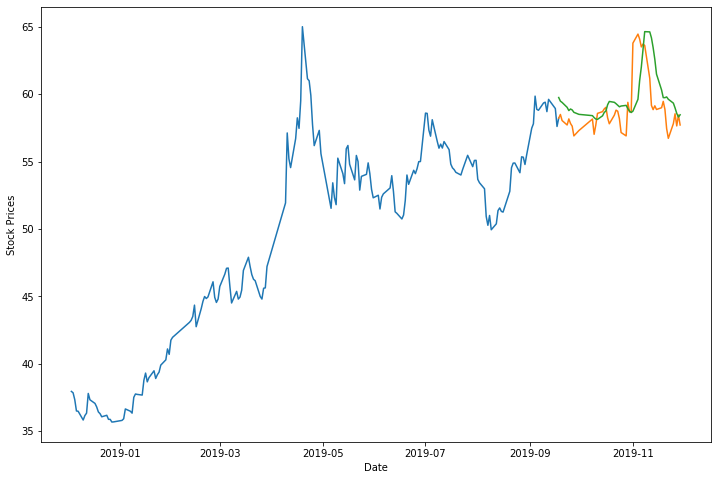

In [18]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
dataset = data.values
train_num=int(len(data)*0.8)
train=dataset[:train_num+1]
test=dataset[train_num:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

pre_num=5
X_train, y_train = [], []
for i in range(pre_num,len(train)):
    X_train.append(scaled_data[i-pre_num:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

inputs = data[len(data) - len(test) - pre_num:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(pre_num,inputs.shape[0]):
    X_test.append(inputs[i-pre_num:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)
lstm_model.summary()

stock_price = lstm_model.predict(X_test)
stock_price = scaler.inverse_transform(stock_price)
print('LSTM Prediction RMSE',np.sqrt(np.mean(np.power((test-stock_price),2))))
# Plot
plt.figure(figsize=(12,8))
train = data[:train_num+1]
test = data[train_num:]
test['Prediction'] = stock_price
plt.plot(train['Close'])
plt.plot(test[['Close','Prediction']])
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.show()